<a href="https://colab.research.google.com/github/PLivdan/Notebooks/blob/main/MultiArmed_Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import pandas as pd
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Environment setup
class SlotMachine:
    def __init__(self, n_arms, true_rewards):
        self.n_arms = n_arms
        self.true_rewards = true_rewards

    def pull(self, arm):
        return np.random.normal(self.true_rewards[arm], 1)

In [ ]:
# Base class for all algorithms
class BanditAlgorithm:
    def __init__(self, n_arms):
        self.n_arms = n_arms

    def select_arm(self):
        raise NotImplementedError

    def update(self, arm, reward):
        raise NotImplementedError

In [ ]:
# Simple exploration algorithms
class EpsilonGreedy(BanditAlgorithm):
    def __init__(self, n_arms, epsilon):
        super().__init__(n_arms)
        self.epsilon = epsilon
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)

    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        return np.argmax(self.q_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

class AdaptiveEpsilonGreedy(BanditAlgorithm):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        epsilon = 1 / np.log(self.t + 1)
        if np.random.random() < epsilon:
            return np.random.randint(self.n_arms)
        return np.argmax(self.q_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

class OptimisticInitialValues(BanditAlgorithm):
    def __init__(self, n_arms, initial_value):
        super().__init__(n_arms)
        self.q_values = np.ones(n_arms) * initial_value
        self.arm_counts = np.zeros(n_arms)

    def select_arm(self):
        return np.argmax(self.q_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

In [ ]:
# Upper Confidence Bound (UCB) algorithms
class UCB(BanditAlgorithm):
    def __init__(self, n_arms, c):
        super().__init__(n_arms)
        self.c = c
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        ucb_values = self.q_values + self.c * np.sqrt(np.log(self.t) / (self.arm_counts + 1e-5))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

class MOSS(BanditAlgorithm):
    def __init__(self, n_arms, T):
        super().__init__(n_arms)
        self.T = T
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        t = np.sum(self.counts) + 1
        ucb_values = self.values + np.sqrt(np.maximum(np.log(self.T / (self.n_arms * np.maximum(self.counts, 1))) / (2 * np.maximum(self.counts, 1)), 0))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

class DiscountedUCB(BanditAlgorithm):
    def __init__(self, n_arms, gamma, c):
        super().__init__(n_arms)
        self.gamma = gamma
        self.c = c
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        ucb_values = self.q_values + self.c * np.sqrt(np.sum(self.gamma**np.arange(self.t-1, -1, -1)) * np.log(self.t) / (self.arm_counts + 1e-5))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] = self.gamma * self.q_values[arm] + (1 - self.gamma) * reward

In [ ]:
# Probability matching algorithms
class ThompsonSampling(BanditAlgorithm):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def select_arm(self):
        return np.argmax(np.random.beta(self.alpha, self.beta))

    def update(self, arm, reward):
        if reward > 0:
            self.alpha[arm] += reward
        else:
            self.beta[arm] += 1 - reward

class BayesUCB(BanditAlgorithm):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def select_arm(self):
        t = np.sum(self.alpha + self.beta)
        quantiles = beta.ppf(1 - 1 / t, self.alpha, self.beta)
        return np.argmax(quantiles)

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

In [ ]:
# Gradient-based algorithms
class GradientBandit(BanditAlgorithm):
    def __init__(self, n_arms, alpha):
        super().__init__(n_arms)
        self.alpha = alpha
        self.H = np.zeros(n_arms)
        self.pi = np.ones(n_arms) / n_arms
        self.average_reward = 0
        self.t = 0

    def select_arm(self):
        return np.random.choice(self.n_arms, p=self.pi)

    def update(self, arm, reward):
        self.t += 1
        self.average_reward += (reward - self.average_reward) / self.t

        for a in range(self.n_arms):
            if a == arm:
                self.H[a] += self.alpha * (reward - self.average_reward) * (1 - self.pi[a])
            else:
                self.H[a] -= self.alpha * (reward - self.average_reward) * self.pi[a]

        exp_H = np.exp(self.H)
        self.pi = exp_H / np.sum(exp_H)


In [ ]:
# Information theory-based algorithms
class KLUCB(BanditAlgorithm):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def kl_divergence(self, p, q):
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

    def select_arm(self):
        t = np.sum(self.counts) + 1
        ucb_values = []
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
            q = self.values[arm]
            u = min(1, q + np.sqrt(np.log(t) / (2 * self.counts[arm])))
            ucb_values.append(u)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

class Exp3(BanditAlgorithm):
    def __init__(self, n_arms, gamma):
        super().__init__(n_arms)
        self.gamma = gamma
        self.weights = np.ones(n_arms)

    def select_arm(self):
        probs = self.calculate_probabilities()
        return np.random.choice(self.n_arms, p=probs)

    def update(self, arm, reward):
        probs = self.calculate_probabilities()
        estimated_reward = reward / probs[arm]
        self.weights[arm] *= np.exp(estimated_reward * self.gamma / self.n_arms)

    def calculate_probabilities(self):
        sum_weights = np.sum(self.weights)
        return (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.n_arms)

In [ ]:
# Contextual bandit algorithms
class LinUCB(BanditAlgorithm):
    def __init__(self, n_arms, d, alpha):
        super().__init__(n_arms)
        self.d = d
        self.alpha = alpha
        self.A = [np.eye(d) for _ in range(n_arms)]
        self.b = [np.zeros((d, 1)) for _ in range(n_arms)]
        self.theta = [np.zeros((d, 1)) for _ in range(n_arms)]

    def select_arm(self, context):
        ucb_values = []
        for arm in range(self.n_arms):
            theta = np.linalg.inv(self.A[arm]).dot(self.b[arm])
            self.theta[arm] = theta
            cb = self.alpha * np.sqrt(context.T.dot(np.linalg.inv(self.A[arm])).dot(context))
            ucb_values.append(context.T.dot(theta) + cb)
        return np.argmax(ucb_values)

    def update(self, arm, reward, context):
        self.A[arm] += context.dot(context.T)
        self.b[arm] += reward * context

In [ ]:
# Elimination algorithms
class MedianElimination(BanditAlgorithm):
    def __init__(self, n_arms, epsilon, delta):
        super().__init__(n_arms)
        self.epsilon = epsilon
        self.delta = delta
        self.active_arms = list(range(n_arms))
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)

    def select_arm(self):
        if len(self.active_arms) == 1:
            return self.active_arms[0]
        return np.random.choice(self.active_arms)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

        if np.min(self.arm_counts[self.active_arms]) >= np.ceil(4 / self.epsilon**2 * np.log(3 / self.delta)):
            median = np.median(self.q_values[self.active_arms])
            self.active_arms = [a for a in self.active_arms if self.q_values[a] >= median]
            self.epsilon *= 3/4
            self.delta *= self.delta

class SuccessiveElimination(BanditAlgorithm):
    def __init__(self, n_arms, delta):
        super().__init__(n_arms)
        self.delta = delta
        self.active_arms = list(range(n_arms))
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        if len(self.active_arms) == 1:
            return self.active_arms[0]
        return self.active_arms[np.argmin(self.arm_counts[self.active_arms])]

    def update(self, arm, reward):
        self.t += 1
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

        if len(self.active_arms) > 1:
            best_arm = self.active_arms[np.argmax(self.q_values[self.active_arms])]
            confidence_interval = np.sqrt(2 * np.log(4 * self.n_arms * self.t**2 / self.delta) / np.maximum(self.arm_counts, 1))

            self.active_arms = [a for a in self.active_arms if
                                a == best_arm or
                                self.q_values[a] + confidence_interval[a] >= self.q_values[best_arm] - confidence_interval[best_arm]]

In [ ]:
# Softmax-based algorithms
class Softmax(BanditAlgorithm):
    def __init__(self, n_arms, temperature):
        super().__init__(n_arms)
        self.temperature = temperature
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)

    def select_arm(self):
        exp_values = np.exp(self.q_values / self.temperature)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.n_arms, p=probs)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

class SoftmaxWithAnnealing(BanditAlgorithm):
    def __init__(self, n_arms, initial_temperature):
        super().__init__(n_arms)
        self.temperature = initial_temperature
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        self.temperature = 1 / np.log(self.t + 1)
        exp_values = np.exp(self.q_values / self.temperature)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.n_arms, p=probs)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

In [ ]:
# Pursuit algorithms
class Pursuit(BanditAlgorithm):
    def __init__(self, n_arms, learning_rate):
        super().__init__(n_arms)
        self.learning_rate = learning_rate
        self.q_values = np.zeros(n_arms)
        self.probs = np.ones(n_arms) / n_arms

    def select_arm(self):
        return np.random.choice(self.n_arms, p=self.probs)

    def update(self, arm, reward):
        self.q_values[arm] += (reward - self.q_values[arm]) / (self.q_values[arm] + 1)
        best_arm = np.argmax(self.q_values)
        for i in range(self.n_arms):
            if i == best_arm:
                self.probs[i] += self.learning_rate * (1 - self.probs[i])
            else:
                self.probs[i] += self.learning_rate * (0 - self.probs[i])
        self.probs /= np.sum(self.probs)

In [ ]:
# New algorithms
class UCB2(BanditAlgorithm):
    def __init__(self, n_arms, alpha):
        super().__init__(n_arms)
        self.alpha = alpha
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)
        self.r = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        for arm in range(self.n_arms):
            if self.arm_counts[arm] == 0:
                return arm

        tau = np.ceil(self.t ** self.alpha).astype(int)
        arm = np.argmax(self.q_values + np.sqrt((1 + self.alpha) * np.log(np.e * self.t / tau) / (2 * tau)))
        return arm

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]
        self.r[arm] = np.ceil((1 + self.alpha) ** self.arm_counts[arm])

class VDBE(BanditAlgorithm):
    def __init__(self, n_arms, sigma, initial_epsilon):
        super().__init__(n_arms)
        self.sigma = sigma
        self.epsilon = initial_epsilon
        self.q_values = np.zeros(n_arms)
        self.arm_counts = np.zeros(n_arms)

    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        return np.argmax(self.q_values)

    def update(self, arm, reward):
        old_q = self.q_values[arm]
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

        delta = abs(old_q - self.q_values[arm])
        f = (1 - np.exp(-delta / self.sigma)) / (1 + np.exp(-delta / self.sigma))
        self.epsilon = self.epsilon * (1 - f) + f / self.n_arms

In [ ]:
# Simulation function
def run_simulation(env, algorithm, n_steps, context_dim=None):
    rewards = []
    for _ in range(n_steps):
        if context_dim is not None:
            context = np.random.randn(context_dim, 1)
            arm = algorithm.select_arm(context)
        else:
            arm = algorithm.select_arm()
        reward = env.pull(arm)
        if context_dim is not None:
            algorithm.update(arm, reward, context)
        else:
            algorithm.update(arm, reward)
        rewards.append(reward)
    return rewards

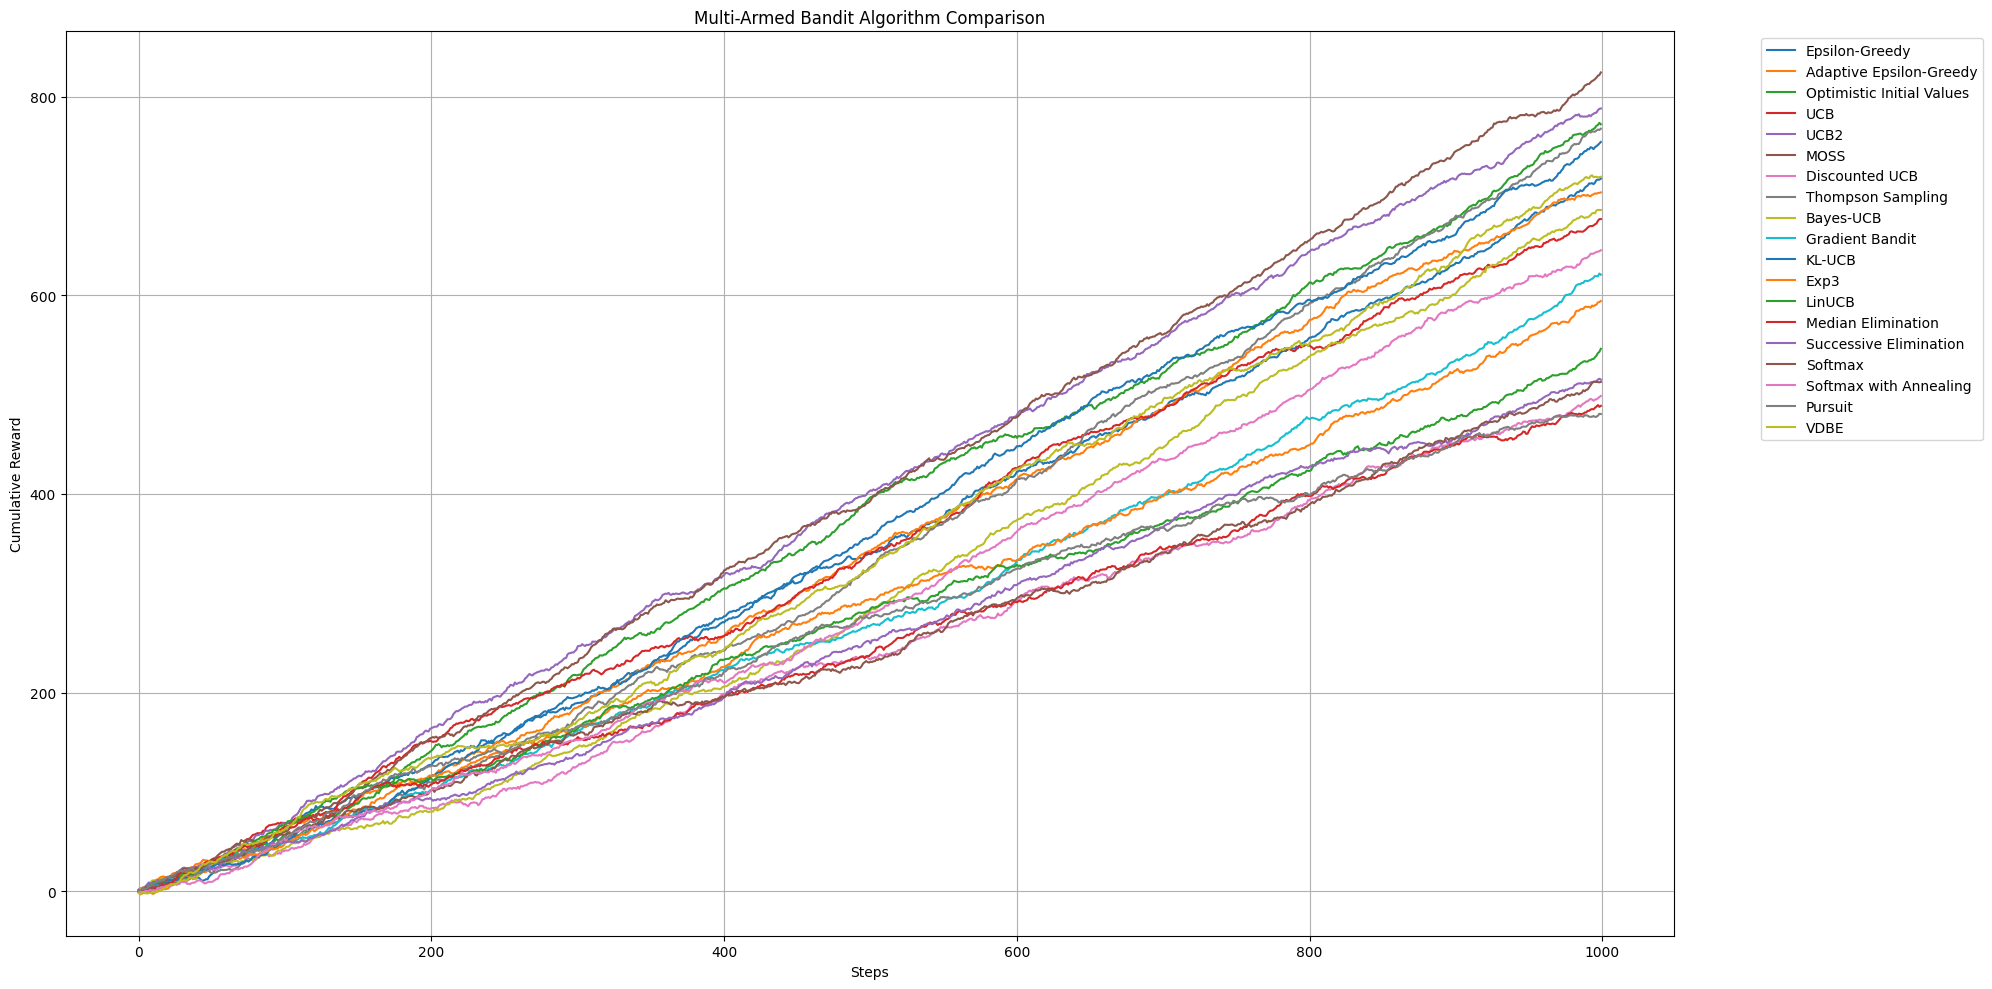

Results Table:
                Algorithm  Total Reward     Regret
                     MOSS    824.381233 -24.197803
                     UCB2    788.086092  12.097339
Optimistic Initial Values    772.202020  27.981410
        Thompson Sampling    767.742490  32.440941
                   KL-UCB    754.351816  45.831615
                     VDBE    719.374821  80.808609
           Epsilon-Greedy    717.471748  82.711683
  Adaptive Epsilon-Greedy    703.613770  96.569661
                Bayes-UCB    685.889827 114.293604
                      UCB    676.762536 123.420895
   Softmax with Annealing    645.393455 154.789976
          Gradient Bandit    620.753207 179.430224
                     Exp3    594.282160 205.901271
                   LinUCB    546.144347 254.039084
   Successive Elimination    515.104146 285.079284
                  Softmax    512.814910 287.368521
           Discounted UCB    498.629979 301.553452
       Median Elimination    488.690861 311.492569
                

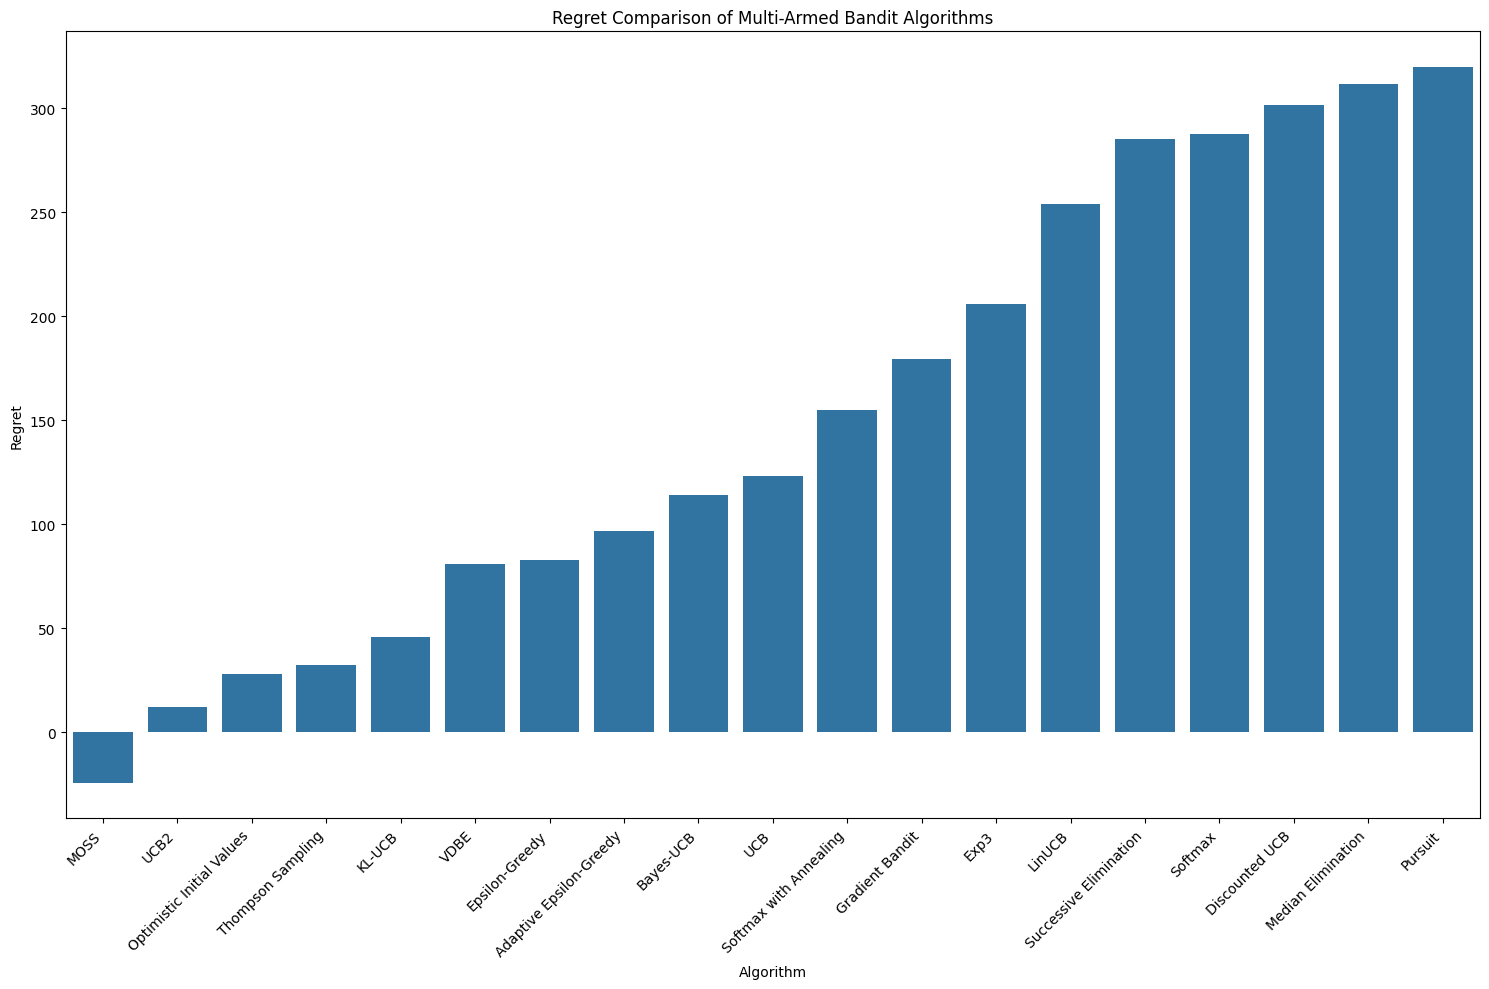

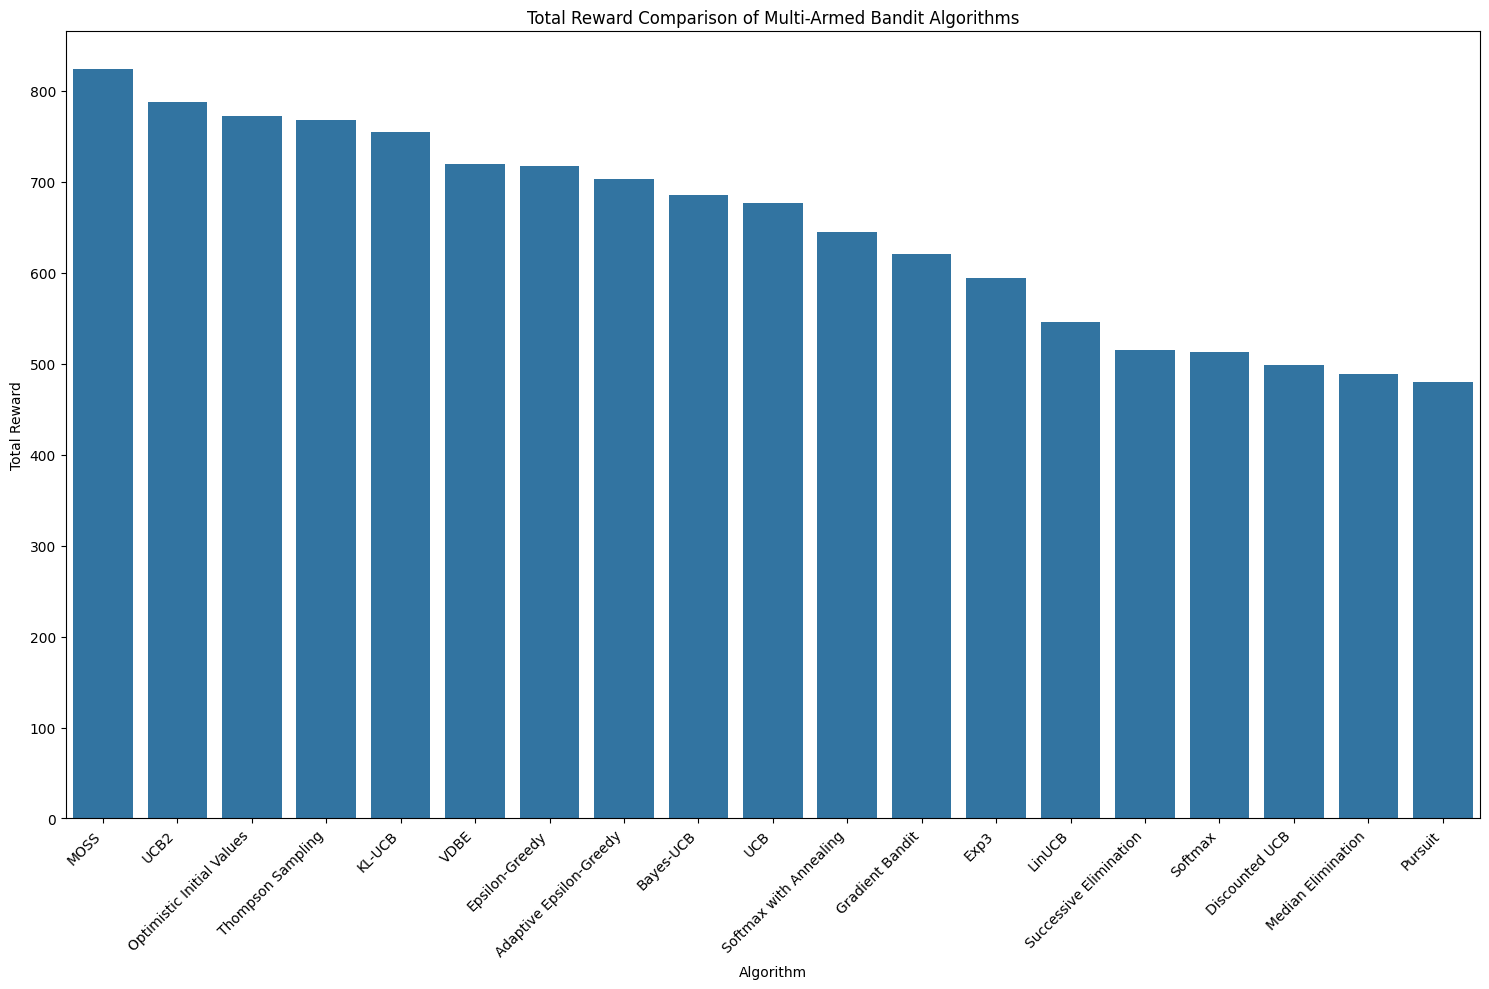

In [ ]:
# Simulation setup
n_arms = 10
true_rewards = np.random.beta(2, 2, n_arms)  # Using Beta distribution for true rewards
env = SlotMachine(n_arms, true_rewards)

n_steps = 1000
context_dim = 5  # for LinUCB

algorithms = {
    'Epsilon-Greedy': EpsilonGreedy(n_arms, 0.1),
    'Adaptive Epsilon-Greedy': AdaptiveEpsilonGreedy(n_arms),
    'Optimistic Initial Values': OptimisticInitialValues(n_arms, 5),
    'UCB': UCB(n_arms, 2),
    'UCB2': UCB2(n_arms, 0.1),
    'MOSS': MOSS(n_arms, n_steps),
    'Discounted UCB': DiscountedUCB(n_arms, 0.95, 2),
    'Thompson Sampling': ThompsonSampling(n_arms),
    'Bayes-UCB': BayesUCB(n_arms),
    'Gradient Bandit': GradientBandit(n_arms, 0.1),
    'KL-UCB': KLUCB(n_arms),
    'Exp3': Exp3(n_arms, 0.1),
    'LinUCB': LinUCB(n_arms, context_dim, 1.0),
    'Median Elimination': MedianElimination(n_arms, 0.1, 0.1),
    'Successive Elimination': SuccessiveElimination(n_arms, 0.1),
    'Softmax': Softmax(n_arms, 0.1),
    'Softmax with Annealing': SoftmaxWithAnnealing(n_arms, 1.0),
    'Pursuit': Pursuit(n_arms, 0.1),
    'VDBE': VDBE(n_arms, 0.1, 0.9),
}

results = {}

for name, alg in algorithms.items():
    if name == 'LinUCB':
        results[name] = run_simulation(env, alg, n_steps, context_dim)
    else:
        results[name] = run_simulation(env, alg, n_steps)

# Plotting cumulative rewards
plt.figure(figsize=(20, 10))
for name, rewards in results.items():
    cumulative_rewards = np.cumsum(rewards)
    plt.plot(cumulative_rewards, label=name)

plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.title('Multi-Armed Bandit Algorithm Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate total rewards and regret
optimal_arm_reward = np.max(true_rewards)
total_rewards = {name: sum(rewards) for name, rewards in results.items()}
regrets = {name: n_steps * optimal_arm_reward - sum(rewards) for name, rewards in results.items()}

# Create a DataFrame for results
df_results = pd.DataFrame({
    'Algorithm': list(algorithms.keys()),
    'Total Reward': [total_rewards[name] for name in algorithms.keys()],
    'Regret': [regrets[name] for name in algorithms.keys()]
})
df_results = df_results.sort_values('Total Reward', ascending=False).reset_index(drop=True)

# Display results table
print("Results Table:")
print(df_results.to_string(index=False))

# Plotting regret comparison
plt.figure(figsize=(15, 10))
sns.barplot(x='Algorithm', y='Regret', data=df_results)
plt.xticks(rotation=45, ha='right')
plt.title('Regret Comparison of Multi-Armed Bandit Algorithms')
plt.tight_layout()
plt.show()

# Plotting reward comparison
plt.figure(figsize=(15, 10))
sns.barplot(x='Algorithm', y='Total Reward', data=df_results)
plt.xticks(rotation=45, ha='right')
plt.title('Total Reward Comparison of Multi-Armed Bandit Algorithms')
plt.tight_layout()
plt.show()